## Problem Statement

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
## Importing libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import load_img
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization


import seaborn as sns
import glob as glob

## Data Reading/Data Understanding → Defining the path for train and test images

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Defining the path for train and test images

train_path = '/content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_path = '/content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

In [5]:

data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [6]:
## removing the output folders if any
## Used for re-running the models

for f in data_dir_train.glob(os.path.join('*', 'output', '*.jpg')):
  os.remove(f)

for out_folder in data_dir_train.glob(os.path.join('*', 'output')):
  os.rmdir(out_folder)

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Insights
1. Train data contains 2239 images
2. Test set contaions 118 images

## Dataset Creation
    - Create train & validation dataset from the train directory with a batch size of 32. 
    - Also, make sure you resize your images to 180*180.

In [8]:
batch_size = 32
img_height = 180
img_width = 180

### Creating train dataset - 80%

In [9]:

## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_train,
        batch_size=batch_size,
        image_size=(img_height,img_width),
        label_mode='categorical',
        seed=123,
        subset="training",
        validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


### Creating validation dataset - 20%

In [10]:

## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_train,
        batch_size=batch_size,
        image_size=(img_height,img_width),
        label_mode='categorical',
        seed=123,
        subset="validation",
        validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### Insights
1. Out of total 2239 total images, 1792 images shall be used for train set 
2. 447 images shall be used for validation set

### Get all the classes in train data set

In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)
print('No of classes - ', len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
No of classes -  9


### Get all the classes in validation data set

In [12]:

class_names_test = val_ds.class_names
print(class_names_test)
print('No of classes - ', len(class_names_test))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
No of classes -  9


### Insights
1. Both test and validation data set contains images belonging to all 9 classes

### Visualize the data

### Dataset visualisation → Create a code to visualize one instance of all the nine classes present in the dataset

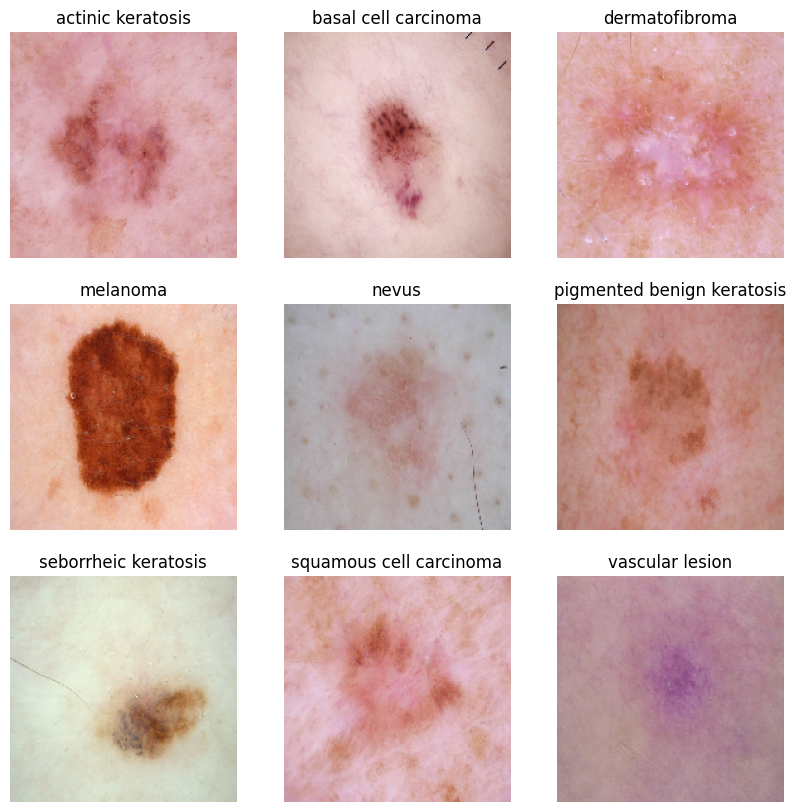

In [14]:
# create a code to visualize one instance of all the nine classes present in the dataset

files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(10,10))
index = 0
for class_name in class_names:
  path_list = files_path_dict[class_name][:1]
  index += 1
  plt.subplot(3,3,index)
  plt.imshow(load_img(path_list[0],target_size=(180,180)))
  plt.title(class_name)
  plt.axis("off")


### Visualize the distribution of data

In [16]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,nevus,357
2,dermatofibroma,95
3,vascular lesion,139
4,pigmented benign keratosis,462
5,seborrheic keratosis,77
6,melanoma,438
7,basal cell carcinoma,376
8,squamous cell carcinoma,181


### BARPLOT :: Visualize the Number of image in each class.

<Axes: xlabel='No. of Image', ylabel='Class'>

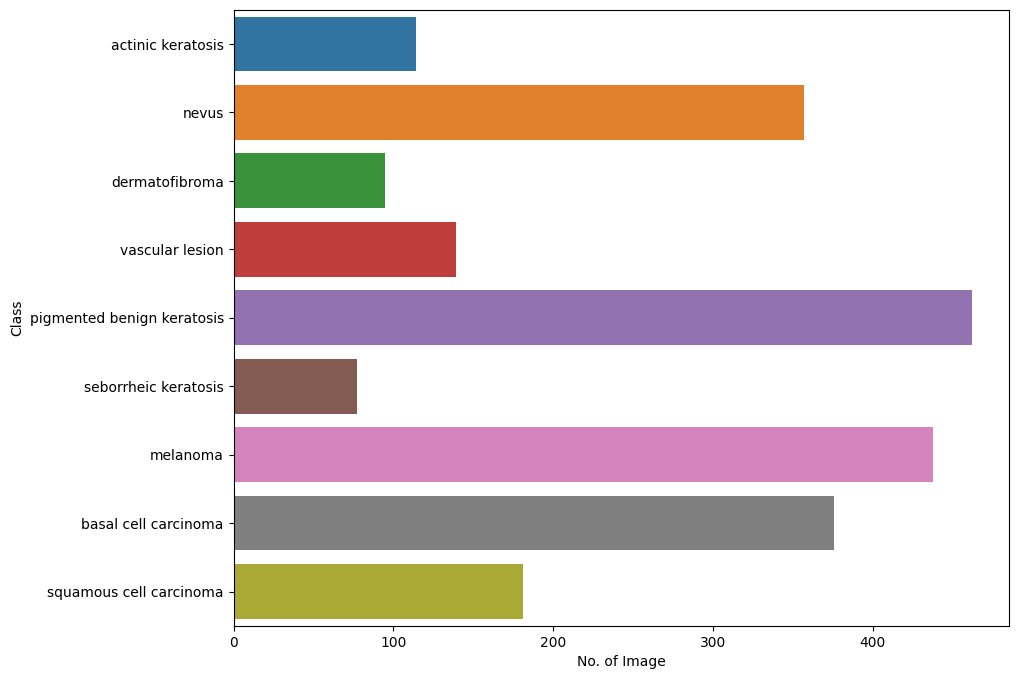

In [17]:

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

### Insights
1. The distribution of images among different classes are not quite balanced
2. `seborrheic keratosis` and `dermatofibroma` classes contains fewer data set
3. `pigmented benign keratosis`, `melanoma` and  `basal cell carcinoma` contains a larger set of images

### Autotune the data

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [18]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building & training :

### 1. Create the CNN model : Model-1 CNN 

Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).

In [21]:
num_classes = len(class_names) # Total number of classes
input_shape = (img_height,img_width,3)

#Sequential allows you to create models layer-by-layer
model = Sequential()    #Sequential allows you to create models layer-by-layer

#First Convulation Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

### 2. compile the model

Choose an appropriate optimiser and loss function for model training

In [23]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3. Train the model

In [24]:
# Train the model for ~20 epochs

In [25]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 315s 1s/step - loss: 2.0200 - accuracy: 0.2215 - val_loss: 1.8919 - val_accuracy: 0.3266
Epoch 2/20
56/56 [==============================] - 3s 59ms/step - loss: 1.7561 - accuracy: 0.3622 - val_loss: 1.6149 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 3s 60ms/step - loss: 1.5680 - accuracy: 0.4275 - val_loss: 1.6244 - val_accuracy: 0.4318
Epoch 4/20
56/56 [==============================] - 3s 58ms/step - loss: 1.5031 - accuracy: 0.4671 - val_loss: 1.4907 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 3s 59ms/step - loss: 1.3689 - accuracy: 0.5206 - val_loss: 1.3933 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 3s 59ms/step - loss: 1.3654 - accuracy: 0.5195 - val_loss: 1.4402 - val_accuracy: 0.4899
Epoch 7/20
56/56 [==============================] - 3s 62ms/step - loss: 1.3124 - accuracy: 0.5268 - val_loss: 1.4035 - val_accuracy: 0.5436
Epoch 8/20
56

### 4. Visualizing training results

In [27]:
## Function to Visualizing training results

def visualize_training_result():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

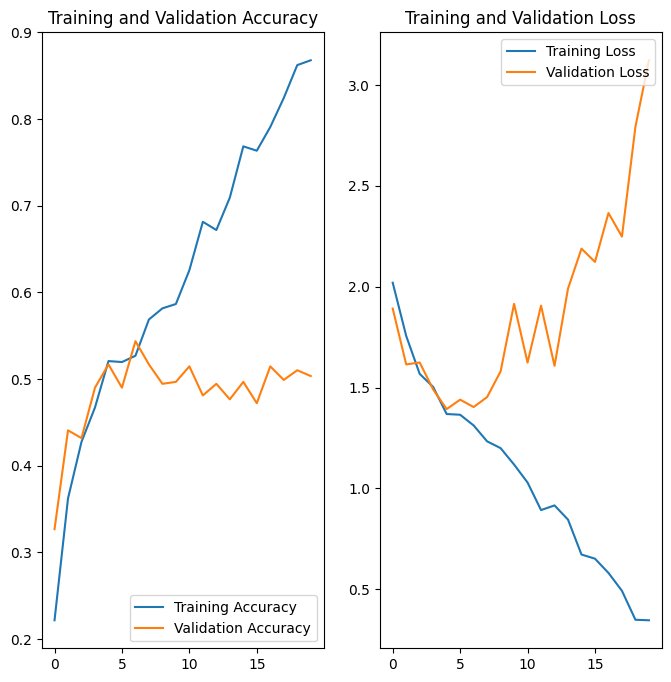

In [28]:
visualize_training_result()

### Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.

### INSIGHTS : CNN model-1
1. The model seem to be overfitting as the test accuracy is about `0.8677` and the validation accuracy is quite less `0.50`
2. Will apply some augmentation for more analysis

## Building Model-2 using Augumentation Strategy

Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

Chose an appropriate data augmentation strategy to resolve underfitting/overfitting

In [31]:
## Defining the data augmentation
data_augument = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3),width_factor=(0.2, 0.3),fill_mode='reflect'),
    layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

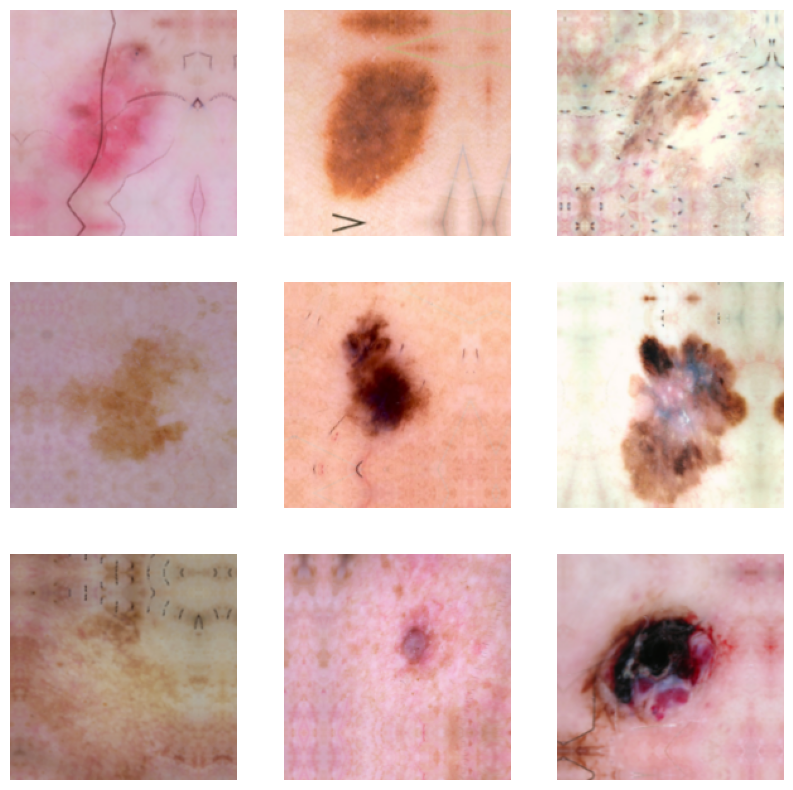

In [32]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        # plt.title(class_names[labels[i]])
        plt.axis("off")



## Model-2 : Applying Augmentation

### Model 2 Creation

In [34]:



#Dropout layer: randomly sets input units to 0 with a frequency of rate at each step during training time,
#which helps prevent overfitting.Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.


## Your code goes here
model2 = Sequential([data_augument,layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3))])                     #Sequential allows you to create models layer-by-layer

#First Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))


model2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 64)        18496     
                                                      

### Compile the model

In [36]:
## Compiling the model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train the model for ~20 epochs

In [38]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 78ms/step - loss: 2.2253 - accuracy: 0.1864 - val_loss: 2.0528 - val_accuracy: 0.2864
Epoch 2/20
56/56 [==============================] - 4s 64ms/step - loss: 1.9224 - accuracy: 0.3002 - val_loss: 1.8697 - val_accuracy: 0.3445
Epoch 3/20
56/56 [==============================] - 4s 63ms/step - loss: 1.7759 - accuracy: 0.3644 - val_loss: 1.8973 - val_accuracy: 0.2841
Epoch 4/20
56/56 [==============================] - 4s 64ms/step - loss: 1.7425 - accuracy: 0.3610 - val_loss: 1.6832 - val_accuracy: 0.3781
Epoch 5/20
56/56 [==============================] - 4s 63ms/step - loss: 1.6492 - accuracy: 0.3884 - val_loss: 1.6080 - val_accuracy: 0.4094
Epoch 6/20
56/56 [==============================] - 3s 62ms/step - loss: 1.6386 - accuracy: 0.4035 - val_loss: 1.5964 - val_accuracy: 0.4206
Epoch 7/20
56/56 [==============================] - 3s 62ms/step - loss: 1.5824 - accuracy: 0.4275 - val_loss: 1.5944 - val_accuracy: 0.4139
Epoch 8/20
56

### Visualizing the results

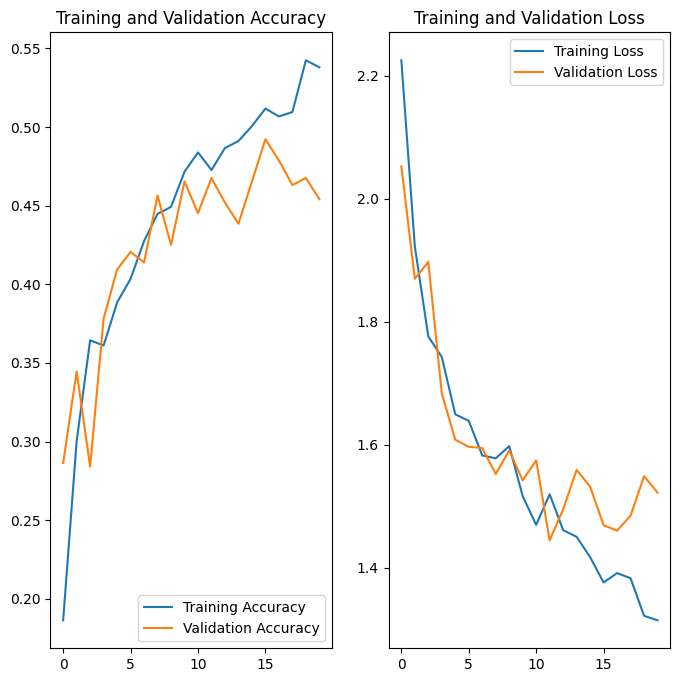

In [39]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Write your findings after the model fit, see if the earlier issue is resolved or not?

## Insights of Model-2
1. The problem of overfitting has been reduced
2. However the obtained accuracy is not that great
3. Will apply Augmentor library for dealing with data imbalance

# Model-3 : Applying Augmentor Library

### Distribution of classes

In [44]:
##
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,/content/gdrive/MyDrive/upGrad/CNN_assignment/...,actinic keratosis
1,/content/gdrive/MyDrive/upGrad/CNN_assignment/...,actinic keratosis
2,/content/gdrive/MyDrive/upGrad/CNN_assignment/...,actinic keratosis
3,/content/gdrive/MyDrive/upGrad/CNN_assignment/...,actinic keratosis
4,/content/gdrive/MyDrive/upGrad/CNN_assignment/...,actinic keratosis


<BarContainer object of 9 artists>

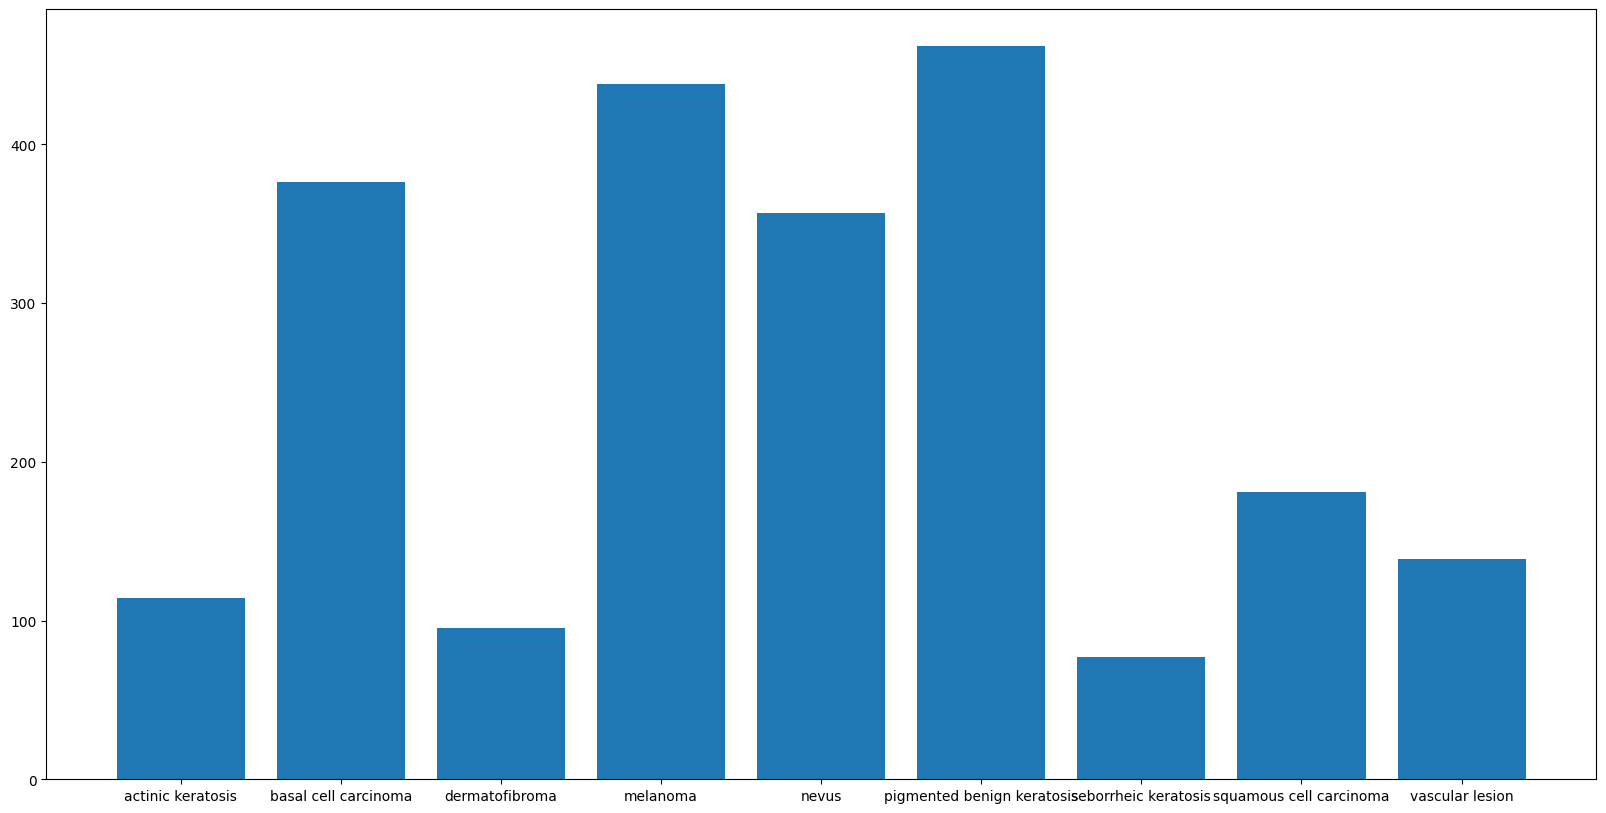

In [45]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(20,10))
plt.bar(class_names,count)

### Insights
1. The distribution of images among different classes are not quite balanced
2. `seborrheic keratosis` and `dermatofibroma` classes contains fewer data set
3. `pigmented benign keratosis`, `melanoma` and  `basal cell carcinoma` contains a larger set of images

### Installing Augmentor library

<b>Context:</b> Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data

<b>Todo:</b> Rectify the class imbalance<br>
<b>Context:</b> You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [46]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [47]:
import Augmentor

path_to_training_dataset="/content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8630093C10>: 100%|██████████| 500/500 [00:30<00:00, 16.32 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F86300FF730>: 100%|██████████| 500/500 [00:31<00:00, 15.87 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F86C5AE3C70>: 100%|██████████| 500/500 [00:34<00:00, 14.64 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7F8630063D90>: 100%|██████████| 500/500 [02:00<00:00,  4.16 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F863048C550>: 100%|██████████| 500/500 [01:51<00:00,  4.47 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F86C5AE3130>: 100%|██████████| 500/500 [00:21<00:00, 22.87 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F863019A020>: 100%|██████████| 500/500 [00:52<00:00,  9.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F86A01F3E80>: 100%|██████████| 500/500 [00:21<00:00, 23.20 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8630199510>: 100%|██████████| 500/500 [00:23<00:00, 21.04 Samples/s]


In [48]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [49]:
path_list = [x for x in data_dir_train.glob(os.path.join('*','output', '*.jpg'))]
path_list

[PosixPath('/content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_7aa63c9b-659c-4e0d-a8ba-cc2a049c6595.jpg'),
 PosixPath('/content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_a6534b10-62ea-4368-9ed6-08dda59747cf.jpg'),
 PosixPath('/content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028990.jpg_1a23733e-9d90-40b6-81a0-8aedfa446c4e.jpg'),
 PosixPath('/content/gdrive/MyDrive/upGrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_d3857576-d1ec-437a-9f4f-b9b8e6fc3611.jpg'),
 PosixPath('/content/gdrive/MyDrive/upGrad/C

In [50]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob(os.path.join('*','output', '*.jpg'))]
lesion_list_new


['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [51]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [52]:
#dataframe that store path and label of the images generated by Augmentor
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [53]:
#label count.
df2['Label'].value_counts()

actinic keratosis             500
nevus                         500
dermatofibroma                500
vascular lesion               500
pigmented benign keratosis    500
seborrheic keratosis          500
melanoma                      500
basal cell carcinoma          500
squamous cell carcinoma       500
Name: Label, dtype: int64

In [54]:
# Todo: Train the model on the data created using Augmentor

In [55]:

batch_size = 32
img_height = 180
img_width = 180

### Todo: Create a training dataset

In [58]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [60]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create your model (make sure to include normalization)

In [69]:
#Sequential allows you to create models layer-by-layer

model3 = Sequential([layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3))])

#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization
#of the layers' inputs by re-centering and re-scaling.
# model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))

#Batch normalization
# model3.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 179, 179, 32)      416       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 88, 88, 64)        8256      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 44, 44, 64)       0         
 g2D)                                                 

### Compile your model (Choose optimizer and loss function appropriately)

In [72]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train model : Using 50 epochs

In [73]:

## Your code goes here, use 50 epochs.
epochs =50
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 44s 235ms/step - loss: 2.3461 - accuracy: 0.1784 - val_loss: 1.8890 - val_accuracy: 0.2947
Epoch 2/50
169/169 [==============================] - 40s 230ms/step - loss: 1.7192 - accuracy: 0.3374 - val_loss: 1.6976 - val_accuracy: 0.3541
Epoch 3/50
169/169 [==============================] - 44s 252ms/step - loss: 1.5415 - accuracy: 0.4063 - val_loss: 1.5002 - val_accuracy: 0.4306
Epoch 4/50
169/169 [==============================] - 40s 231ms/step - loss: 1.4850 - accuracy: 0.4243 - val_loss: 1.4153 - val_accuracy: 0.4425
Epoch 5/50
169/169 [==============================] - 42s 243ms/step - loss: 1.3589 - accuracy: 0.4729 - val_loss: 1.3003 - val_accuracy: 0.4915
Epoch 6/50
169/169 [==============================] - 41s 237ms/step - loss: 1.2737 - accuracy: 0.5128 - val_loss: 1.2185 - val_accuracy: 0.5353
Epoch 7/50
169/169 [==============================] - 42s 244ms/step - loss: 1.1750 - accuracy: 0.5453 - val_loss: 1.1268 - val_accuracy: 0.6

### Visualize the model result

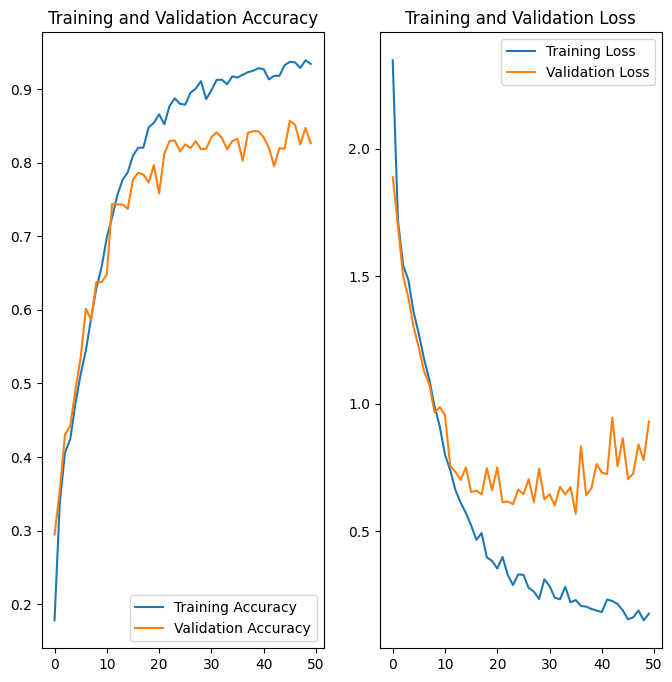

In [74]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

## Insights of Model -3
1. The model is slightly overfitting however much better than model-1 and model-2
2. The accuracy is also seems to be better
3. The final accuracy for test is `0.9342` and that of validation is `0.8263`
4. Validation loss is also quite reduced to `0.9309`